# Visualization of Spotify songs data

In [1]:
import pandas as pd
import numpy as np
from typing import List
import plotly.express as plte
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import seaborn as sb
import re

from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, BasicTicker, PrintfTickFormatter, HoverTool
from bokeh.plotting import show, figure
from bokeh.palettes import Viridis256
from bokeh.transform import transform
from bokeh.io import output_notebook
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive

output_notebook()

Mount my drive into Google Colab in order to load the dataset from the data directory

In [2]:
drive.mount('my_drive')

Drive already mounted at my_drive; to attempt to forcibly remount, call drive.mount("my_drive", force_remount=True).


In [3]:
data_directory = 'my_drive/MyDrive/Colab Notebooks/dataset/'

In our main dataset *data.csv* file a song is described using various features, some of them are:
*   valence
*   year
*   acousticness
*   danceability
*   duration_ms
*   energy
*   explicit
*   id
*   instrumentalness
*   key
*   liveness
*   loudness
*   mode
*   popularity
*   release_date
*   speechiness
*   tempo

The initial data has a column called *duration_ms* which represents the duration of a song in miliseconds, for a better understanding we will convert the duration to seconds

In [4]:
def convert_ms_to_seconds(nr_ms):
    return nr_ms // 1000

In [5]:
data = pd.read_csv(f'{data_directory}data.csv')
data['duration_ms'] = data['duration_ms'].apply(convert_ms_to_seconds)
data.rename(columns={'duration_ms': 'duration_seconds'}, inplace=True)

Among the features listed above we notice that the *release_date* and *year* features are similar, the only difference between these 2 columns being that *release_date* is more specific only for some songs. For this reason we can stick to only *year* column.

Also the *id* feature is not so useful, this column represting an identification string for the song.

As a result we drop the columns *realease_date* and *id* from the dataset.

In [6]:
data = data.drop(columns=['release_date', 'id'])

It might be interesting to visualize how the music industry is changing over the years (1921-2020) by plotting the number of released songs each year.

In [7]:
nr_songs_per_year = {}
for song_year in data['year']:
    if song_year in nr_songs_per_year:
        nr_songs_per_year[song_year] += 1
    else:
        nr_songs_per_year[song_year] = 1

nr_songs_per_year_df = pd.DataFrame(columns=['year', 'nr_songs_released'])
for year in nr_songs_per_year:
    nr_songs_per_year_df = nr_songs_per_year_df.append(
        {'year': year, 'nr_songs_released': nr_songs_per_year[year]},
        ignore_index=True
    )

In [8]:
fig_nr_songs_per_year = plte.bar(
    data_frame=nr_songs_per_year_df,
    x='year',
    y='nr_songs_released',
    color='nr_songs_released',
    title='How the music industry incresed over the years 1921-2020'
)
fig_nr_songs_per_year.show()

![nr-songs-per-year.PNG](https://drive.google.com/uc?id=18x2uXrvu6lpcTy5XtuO1OGqumY5GP0sd)

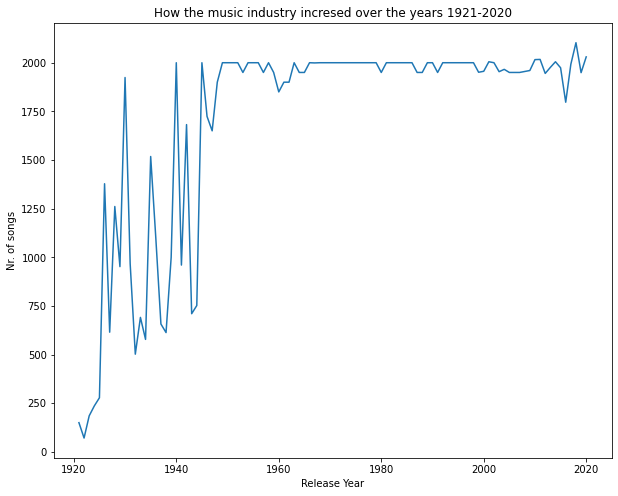

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
release_years = nr_songs_per_year_df['year']
nr_of_songs = nr_songs_per_year_df['nr_songs_released']

ax.set_title('How the music industry incresed over the years 1921-2020')
ax.set_xlabel('Release Year')
ax.set_ylabel('Nr. of songs')
ax.plot(release_years, nr_of_songs)

In [10]:
fig_nr_songs_per_year_line = plte.line(
    data_frame=nr_songs_per_year_df,
    x='year',
    y='nr_songs_released',
    line_shape='spline',
    title='How the music industry increased over the years 1921-2020',
    color_discrete_sequence=['#00CC99']
)
fig_nr_songs_per_year_line.show()

In order to visualize the above plotly plot into GitHub, a screenshot of the plot is attached:

![link text](https://drive.google.com/uc?id=1V_75SCId7YlS32CEqMaATRkuLL6vckx3)



Let's also see what are the most popular songs music genres.

In [11]:
songs_genres_data = pd.read_csv(f'{data_directory}genre_music.csv')

1.   Determine the unique music genres in our dataset
2.   Count how many songs are for each music genre

In [12]:
unique_genres = songs_genres_data['genre'].unique()
print(f'Total nr. of unique genres: {len(unique_genres)}')
print(f'The songs can have one of the following genres: {unique_genres}')

Total nr. of unique genres: 6
The songs can have one of the following genres: ['edm' 'pop' 'r&b' 'rock' 'rap' 'latin']


In [13]:
songs_count_per_genre = {}

for music_genre in songs_genres_data['genre']:
  if music_genre in songs_count_per_genre:
    songs_count_per_genre[music_genre] += 1
  else:
    songs_count_per_genre[music_genre] = 1

print(songs_count_per_genre)

{'edm': 1515, 'pop': 16460, 'r&b': 11040, 'rock': 6850, 'rap': 2364, 'latin': 2870}


In [14]:
labels = [music_genre for music_genre in songs_count_per_genre]
values = [songs_count_per_genre[music_genre] for music_genre in songs_count_per_genre]

In [15]:
pie_plot_colors =  ['#96D190', '#C391D9', '#D991B6',
                    '#D9AD91', '#D4D991', '#91B3D9']

songs_genres_fig = go.Figure(
    data=[go.Pie(
        labels=labels,
        values=values,
        textinfo='label+percent',
        insidetextorientation='radial',
        hole=.3,
        marker_colors=pie_plot_colors
        )]
)
songs_genres_fig.update_layout(
    title_text='Music Genres Predominance'
)
songs_genres_fig.show()

In order to visualize the above plotly plot into GitHub, a screenshot of the plot is attached:

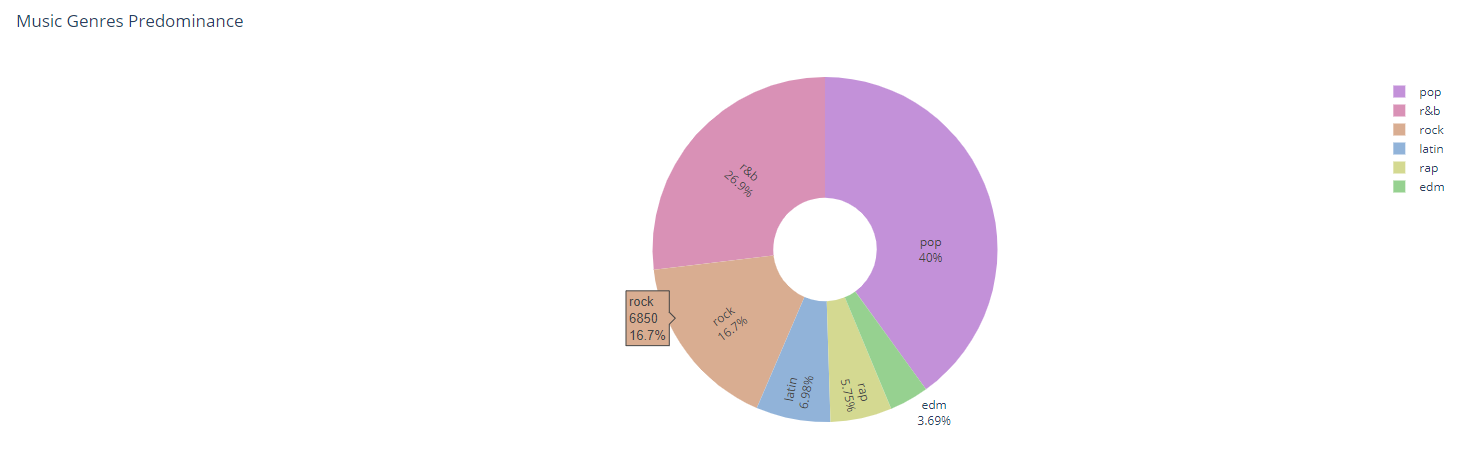

If we were to use this dataset in a machine learning problem, before training any model on the dataset it is good to check first the **correlation between the features** used in the training process.


For example, such a task could be to predict the popularity of a song based on the remained features from the dataset, as a result we are interested to see how correlated the popularity column is with the other columns.


This could help to further decide which columns from the dataset are important in the prediction task of the popularity, determing the columns used in the training process of the models.


For this matter we can build a **heatmap** matrix for a better visualization of the correlation between the features and some individual plots if we want to understand deeper the correlation between 2 specific features:

*   Correlation between all features using heatmap visualization approach
*   Correlation plot between *popularity* and *year* features
*   Correlation plot between *popularity* and *duration_seconds* features



In [16]:
data_shuffled = data.sample(frac=1)

From the following visualization of the correlatation matrix we can see that the 3 most correlated features with *popularity* are (all numbers represent the correlation coefficient based on Pearson formula):
*   year - 0.86
*   energy - 0.49
*   loudness - 0.46



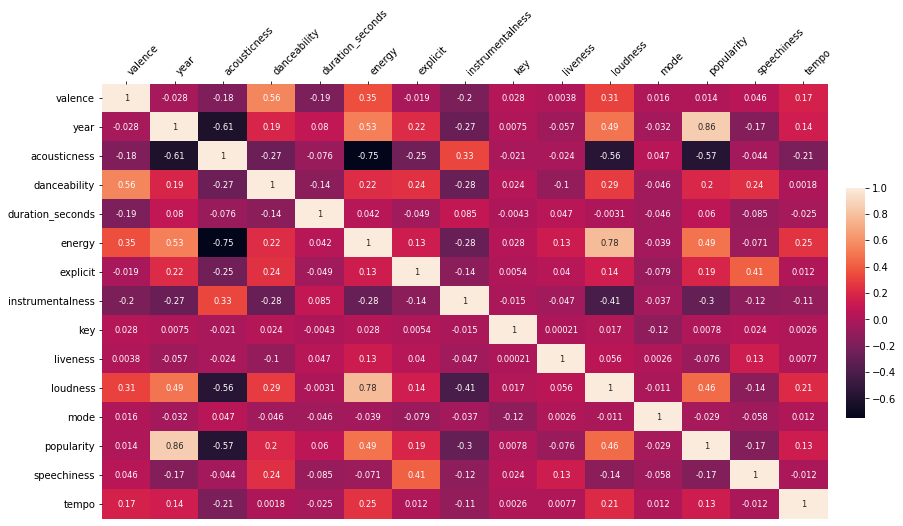

In [17]:
fig, ax = plt.subplots()
ax.xaxis.tick_top()
fig.set_size_inches(13, 8)
cbar_ax = fig.add_axes([.92, .3, .02, .4])
sb.set(font_scale=0.7)
heat_map = sb.heatmap(
    data_shuffled.corr(),
    ax=ax,
    cbar_ax=cbar_ax,
    xticklabels=data_shuffled.corr().columns,
    yticklabels=data_shuffled.corr().columns,
    annot=True
)
heat_map.set_xticklabels(
    heat_map.get_xticklabels(),
    rotation=45,
    horizontalalignment='left'
)
plt.show()

From the following illustrations we can observe that there is a *low* correlation between the *popuarity* and *duration_seconds* features and a *high* correlation between *popularity* and *year* features.

Text(0.5, 1.0, 'Popularity vs Release Year features correlation')

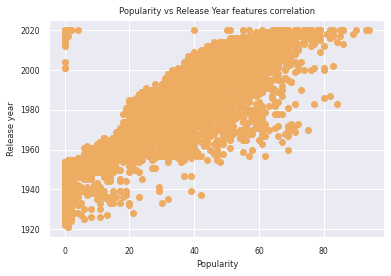

In [18]:
plt.scatter(data_shuffled['popularity'][:5000], data_shuffled['year'][:5000], c='#EDAC61')
plt.xlabel('Popularity')
plt.ylabel('Release year')
plt.title('Popularity vs Release Year features correlation')

Text(0.5, 1.0, 'Popularity vs Duration in seconds features correlation')

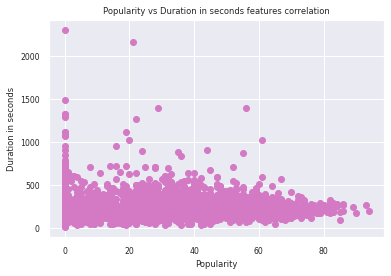

In [19]:
plt.scatter(data_shuffled['popularity'][:5000], data_shuffled['duration_seconds'][:5000], c='#D479C4')
plt.xlabel('Popularity')
plt.ylabel('Duration in seconds')
plt.title('Popularity vs Duration in seconds features correlation')

Also, another good practice before starting thinking about what AI models should we apply on our dataset is to analyze the dataset's **features distribution**.

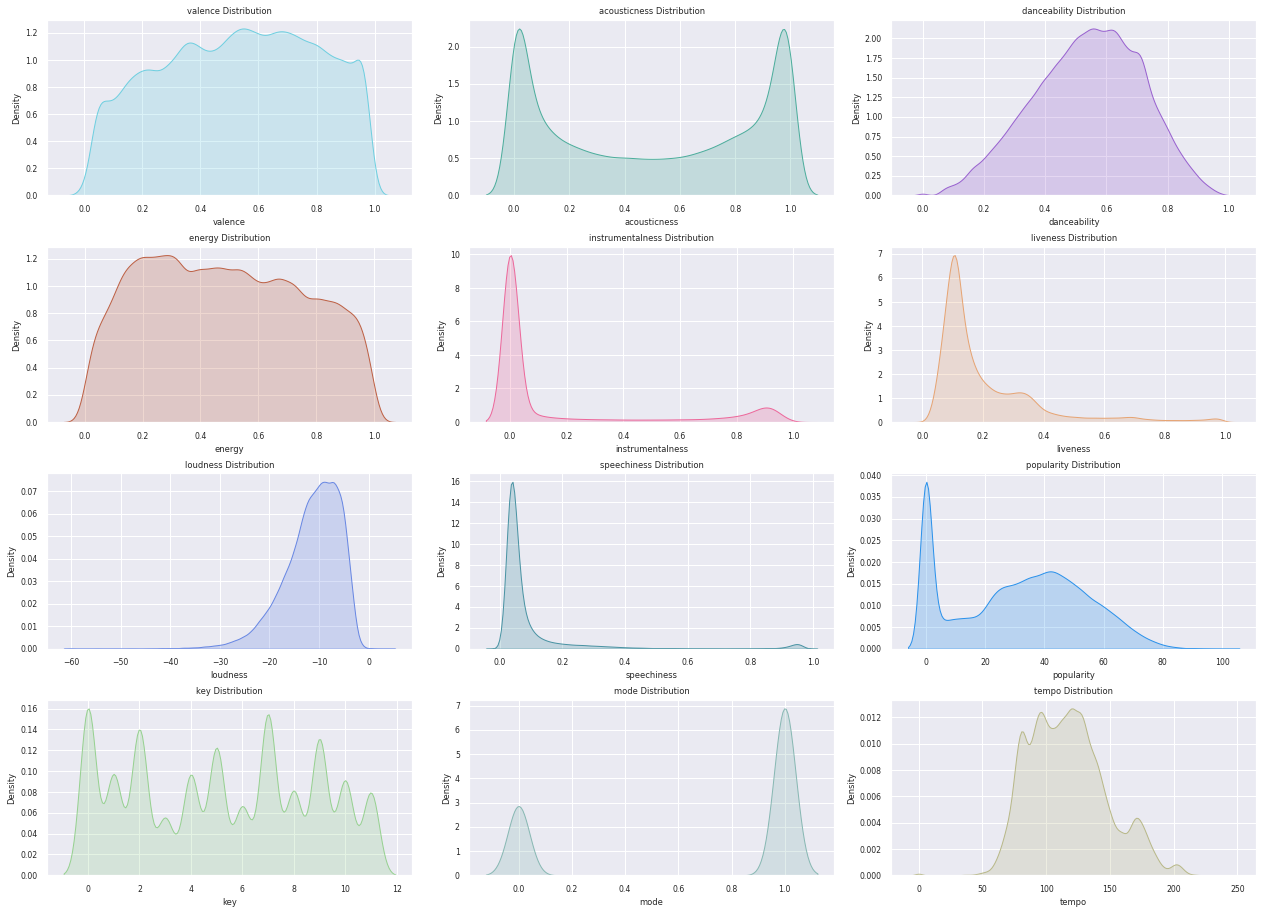

In [20]:
features_distribution_fig, features_distribution_axes = plt.subplots(
    figsize=(18, 13),
    nrows=4,
    ncols=3
)
features_distribution_fig.tight_layout(pad=3.5)

colors = ['#6ECFE0', '#4CAD9C', '#9861CF',
          '#BD6044', '#ED689B', '#E6A473',
          '#6887E3', '#4993A3', '#2A91EB',
          '#96D190', '#88B8B3', '#B8B888']
color_idx = 0

features_list = ['valence', 'acousticness', 'danceability',
                 'energy', 'instrumentalness', 'liveness',
                 'loudness', 'speechiness', 'popularity',
                 'key', 'mode', 'tempo']
feature_idx = 0

for row in range(4):
  for col in range(3):
    feature_name = features_list[feature_idx]
    plot_color = colors[color_idx]

    sb.kdeplot(
      ax=features_distribution_axes[row, col],
      data=data_shuffled,
      x=feature_name,
      fill=True,
      color=plot_color
    )
    features_distribution_axes[row, col].set_title(f'{feature_name} Distribution')

    feature_idx += 1
    color_idx += 1

In the following plot we could easily visualize the different distribution of the *danceability* feature for each of the song's *mode* category.

The mode of a song on Spotify indicates its modality (major or minor), more precise it is the type of scale from which its melodic content is derived.

*Major mode* is represented by 1 and *minor mode* is 0.

In [21]:
songs_mode = data_shuffled['mode']
unique_song_modes = songs_mode.unique()
print(f'A song can be categorized in {len(unique_song_modes)} modes with values: {unique_song_modes}')

A song can be categorized in 2 modes with values: [1 0]


By visualizing the distribution plot below, we can come to the conclusion that in our dataset there are *more songs in major mode which are danceable* than in minor mode.

Text(0, 0.5, 'Density')

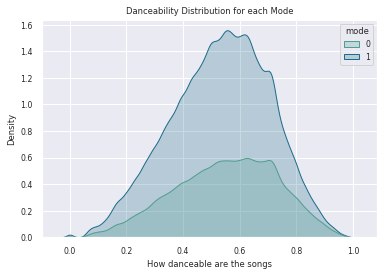

In [22]:
sb.kdeplot(
    data=data_shuffled,
    x='danceability',
    hue='mode',
    bw_adjust=0.7,
    fill=True,
    palette='crest'
)
plt.title('Danceability Distribution for each Mode')
plt.xlabel('How danceable are the songs')
plt.ylabel('Density')

It might be also interesting to see how the distribution of the *danceability* feature changes over the years. For this we chose 5 years from different periods between 1921 and 2020 in order to better see the difference between time periods: 1921, 1950, 1980, 2010, 2020.

We can also make the remark that by the year 2020 the number of *songs in minor mode* is *closer* to the number of *songs in major mode*.

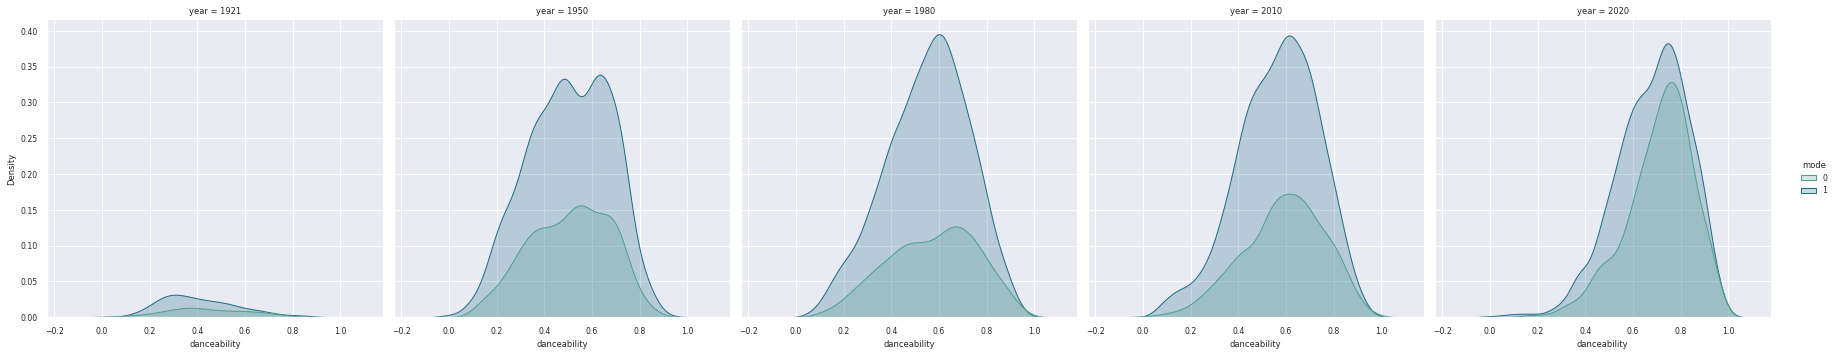

In [23]:
years = [1921, 1950, 1980, 2010, 2020]
sb.displot(
    data=data_shuffled[data_shuffled.year.isin(years)],
    x='danceability',
    hue='mode',
    col='year',
    kind='kde',
    fill=True,
    palette='crest'
)

Let's also visualize the *distribution of the popularity* for each type of mode (major - 1 and minor - 0)

In [24]:
songs_popularity = data_shuffled['popularity']
unique_song_popularities = songs_popularity.unique()
print(f"A song's popularity can have the following values: {unique_song_popularities}")
print(f'Nr. popularities: {len(unique_song_popularities)}')

A song's popularity can have the following values: [ 19  31  63  50  74   0  33  46   1  70  37  36  15  40  45  32  49  58
  59  10  38  25  21  39  43  18  44  34   2  20   5  12  13  26   7  41
  29  57  51   4   8  67  24  30  48  68  47   3  54  61  35  23  52  42
  17  65  71  55  56  16  62  53  28   9  27  64  14  60  75  22   6  69
  66  77  11  72  93  76  78  79  82  94  73  80  86  83  81  90  89  84
  85  87  91  88  97  99  96  92  95 100]
Nr. popularities: 100


In [25]:
songs_mode_0 = data_shuffled[data_shuffled['mode'] == 0]
songs_mode_1 = data_shuffled[data_shuffled['mode'] == 1]
popularity_values_per_mode = [songs_mode_0['popularity'].tolist(), songs_mode_1['popularity'].to_list()]

From the plot below we can see that the popularity distributions for each mode are very similar to one another, unlike the danceability distribution where there is a significant difference between the 2 types of modes.

In [26]:
popularity_distribution = ff.create_distplot(
    hist_data=popularity_values_per_mode,
    group_labels=['popularity distribution - mode 0', 'popularity distribution - mode 1'],
    show_hist=False,
    show_rug=False,
    colors=['#4EB593', '#7B5ECC']
)
popularity_distribution.layout.update(
    {'title': 'Popularity Distribution for each mode (0 and 1)', 'xaxis': {'title': 'popularity'}}
)
popularity_distribution.show()

In order to visualize the above plotly plot into GitHub, a screenshot of the plot is attached:

![link text](https://drive.google.com/uc?id=1RHlhmll0R4VDRhEn2VWMgHz50F6ctqst)

Like we did with the danceability feature, let's see how the *popularity distribution* changes over the years. We stick with the same years, 1921, 1950, 1980, 2010, 2020.

By visualizing the plots we can see that the shape of the popularity distribution is changing a lot between these time periods.

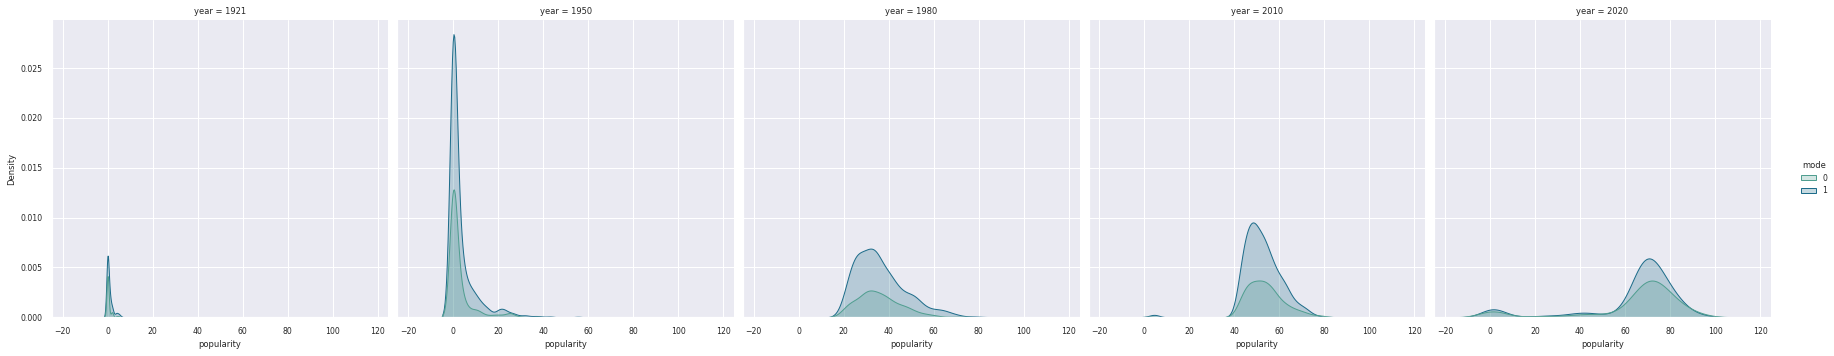

In [27]:
years = [1921, 1950, 1980, 2010, 2020]
sb.displot(
    data=data_shuffled[data_shuffled.year.isin(years)],
    x='popularity',
    hue='mode',
    col='year',
    kind='kde',
    fill=True,
    palette='crest'
)

Another interesting feature is the *key*. For a song, this feature represents the estimated overall key of the song. Integers map to pitches using standard Pitch Class notation. For example, 0 = C, 1 = C♯/D♭, 2 = D etc.

In [28]:
unique_keys = data_shuffled['key'].unique()
print(f'Unique keys: {unique_keys}')
print(f'Total nr. of unique keys: {len(unique_keys)}')

Unique keys: [ 5  9  1  4  6 10  2  7 11  0  3  8]
Total nr. of unique keys: 12


In [29]:
songs_count_per_key = {}

for key in unique_keys:
  current_key_songs = data_shuffled[data_shuffled['key'] == key]
  songs_count_per_key[key] = len(current_key_songs.index)

print(songs_count_per_key)

{5: 16430, 9: 17571, 1: 12886, 4: 12933, 6: 8741, 10: 12148, 2: 18823, 7: 20803, 11: 10670, 0: 21600, 3: 7297, 8: 10751}


In [30]:
key_pie_plot_labels = [f'Key {key}' for key in songs_count_per_key]
key_pie_plot_values = [songs_count_per_key[key] for key in songs_count_per_key]

In [31]:
pie_plot_colors = ['#6ECFE0', '#4CAD9C', '#9861CF',
                   '#BD6044', '#ED689B', '#E6A473',
                   '#6887E3', '#4993A3', '#2A91EB',
                   '#96D190', '#88B8B3', '#B8B888']

In [32]:
songs_keys_fig = go.Figure(
    data=[go.Pie(
        labels=key_pie_plot_labels,
        values=key_pie_plot_values,
        textinfo='label+percent',
        insidetextorientation='radial',
        marker_colors=pie_plot_colors
        )]
)
songs_keys_fig.update_layout(
    title_text='Key Predominance'
)
songs_keys_fig.show()

In order to visualize the above plotly plot into GitHub, a screenshot of the plot is attached:

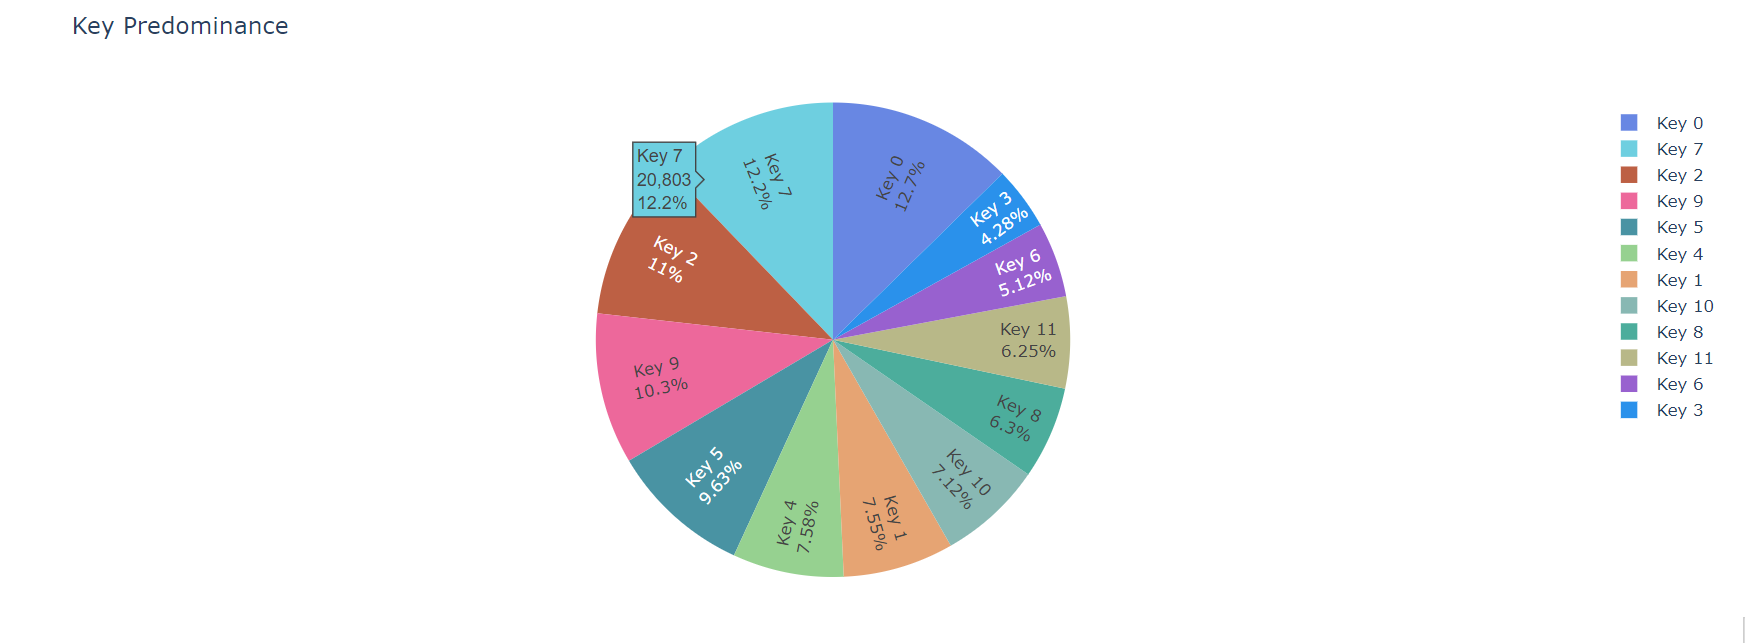

In [33]:
keys_list = [key for key in songs_count_per_key]

songs_keys_fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type': 'domain'}, {'type': 'xy'}]],
    subplot_titles=['Pie Visualization', 'Histogram Visualization']
)

songs_keys_fig.add_trace(
    go.Pie(labels=key_pie_plot_labels, values=key_pie_plot_values, textinfo='label+percent', insidetextorientation='radial', marker_colors=pie_plot_colors),
    row=1,
    col=1
)
songs_keys_fig.add_trace(
    go.Bar(
        x=[key for key in songs_count_per_key],
        y=[songs_count_per_key[key] for key in songs_count_per_key],
        marker={'color': keys_list, 'colorscale': 'viridis'}
    ),
    row=1,
    col=2
)

songs_keys_fig.update_layout(
    title_text='Songs Key Predominance'
)
songs_keys_fig.show()

In order to visualize the above plotly plot into GitHub, a screenshot of the plot is attached:

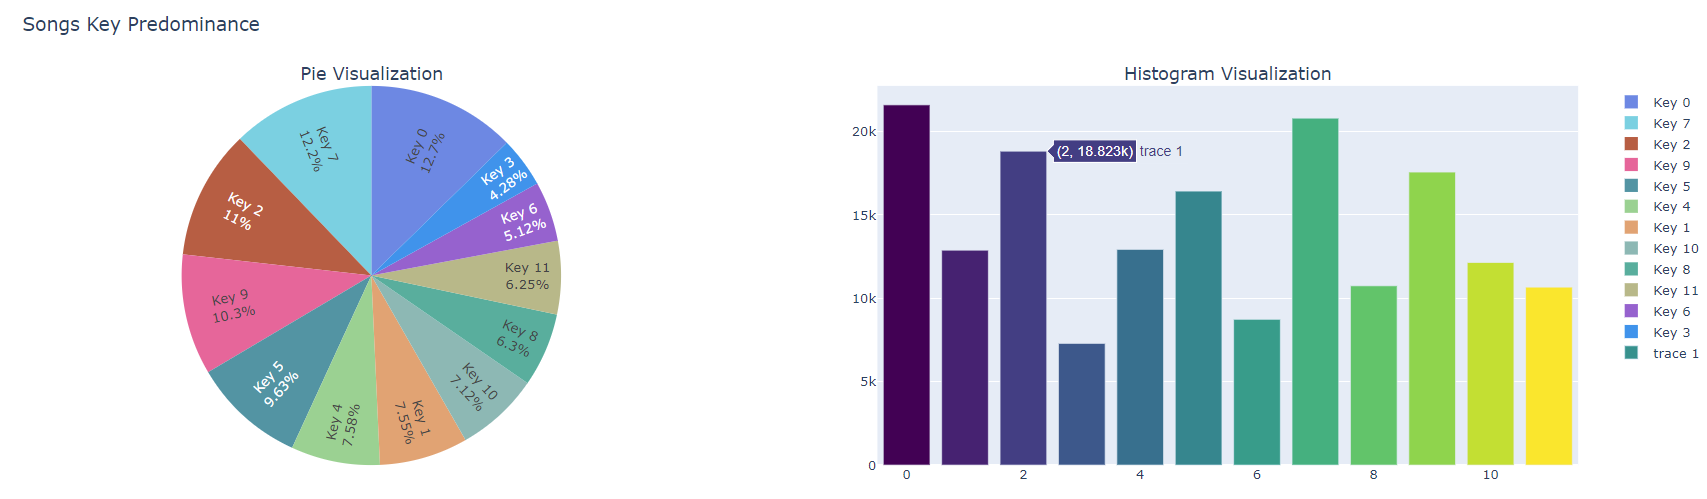

We might want to see the difference between the keys predominance for the songs that are in *major mode* and the ones in *minor mode*.

In [34]:
songs_count_per_key_and_modes = {}

for key in unique_keys:
  current_key_songs = data_shuffled[data_shuffled['key'] == key]
  current_key_songs_mode_0 = current_key_songs[current_key_songs['mode'] == 0]
  current_key_songs_mode_1 = current_key_songs[current_key_songs['mode'] == 1]
  songs_count_per_key_and_modes[key] = (len(current_key_songs_mode_0.index), len(current_key_songs_mode_1.index))

print(songs_count_per_key_and_modes)

{5: (5595, 10835), 9: (5806, 11765), 1: (3331, 9555), 4: (5570, 7363), 6: (3643, 5098), 10: (4265, 7883), 2: (4120, 14703), 7: (4151, 16652), 11: (5753, 4917), 0: (4160, 17440), 3: (1618, 5679), 8: (2006, 8745)}


In [35]:
key_mode_pie_plot_labels = [f'Key {key}' for key in songs_count_per_key_and_modes]
key_pie_plot_values_mode_0 = [count_mode_0 for key, (count_mode_0, _) in songs_count_per_key_and_modes.items()]
key_pie_plot_values_mode_1 = [count_mode_1 for key, (_, count_mode_1) in songs_count_per_key_and_modes.items()]

In [36]:
key_mode_pie_fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type':'domain'}, {'type':'domain'}]]
)
key_mode_pie_fig.add_trace(
    go.Pie(labels=key_mode_pie_plot_labels, values=key_pie_plot_values_mode_0, name="Minor Mode", marker_colors=pie_plot_colors),
    row=1,
    col=1
)
key_mode_pie_fig.add_trace(
    go.Pie(labels=key_mode_pie_plot_labels, values=key_pie_plot_values_mode_1, name="Major Mode", marker_colors=pie_plot_colors),
    row=1,
    col=2
)

key_mode_pie_fig.update_traces(hole=.5, hoverinfo="label+percent+name")

ann_mode_0 = {'text': 'Minor Mode (0)', 'x': 0.18, 'y': 0.5, 'font_size': 20, 'showarrow': False}
ann_mode_1 = {'text': 'Major Mode (1)', 'x': 0.82, 'y': 0.5, 'font_size': 20, 'showarrow': False}
key_mode_pie_fig.update_layout(
    title_text='Songs Keys Predominance for each Mode',
    annotations=[ann_mode_0, ann_mode_1])
key_mode_pie_fig.show()

In order to visualize the above plotly plot into GitHub, a screenshot of the plot is attached:

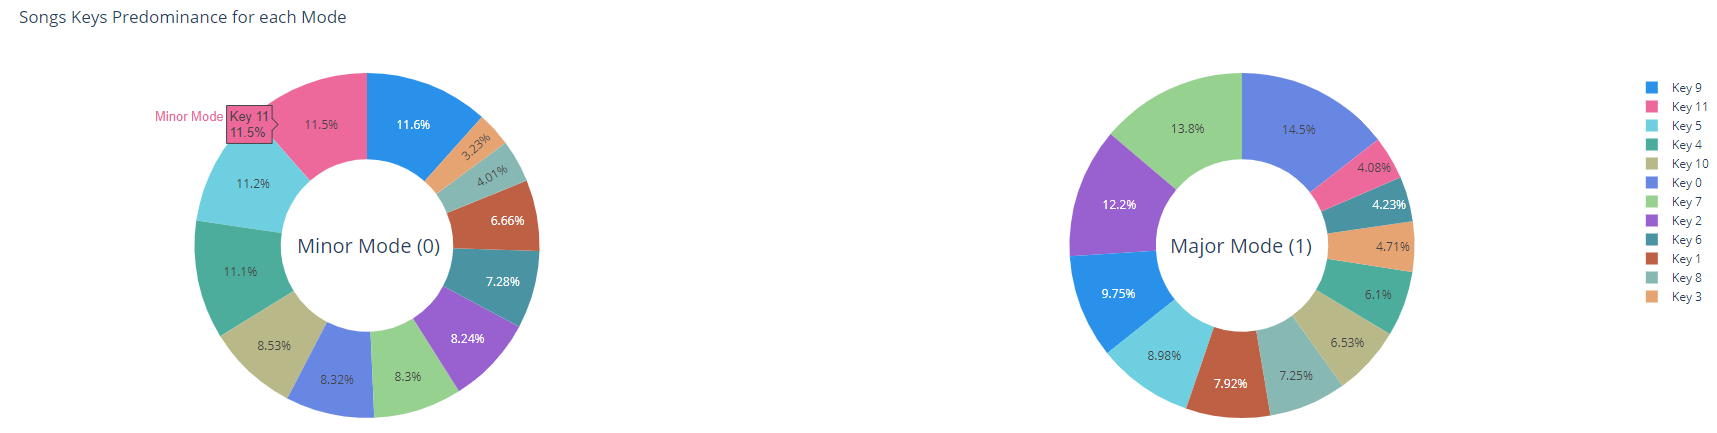

In [37]:
plt.rcParams["figure.figsize"] = [9,6]

# Automatically extract numerical columns.
data = songs_genres_data
data_numerical_columns: List[str] = [column for column in list(data.columns) if type(list(data[column])[0]) in [float]]

# Select a subset of representatibe categorical columns.
data_categorical_columns = ["genre", "popularity"]

# Print selected columns.
print(data_numerical_columns)
print(data_categorical_columns)

['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s', 'chorus_hit']
['genre', 'popularity']


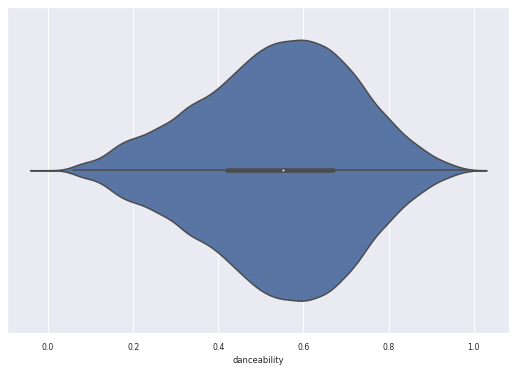

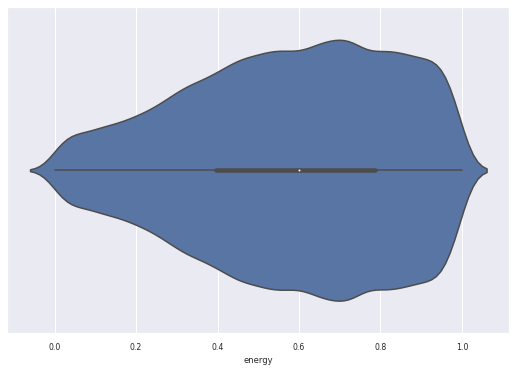

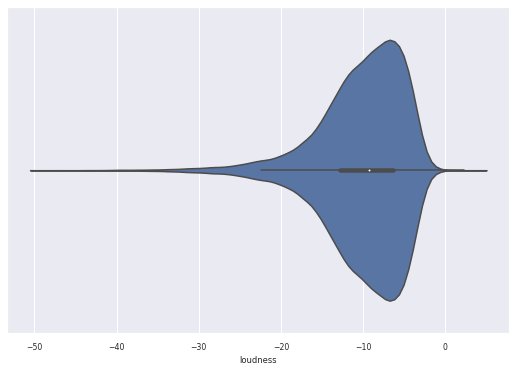

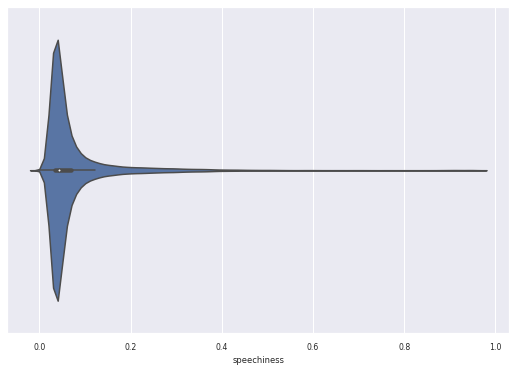

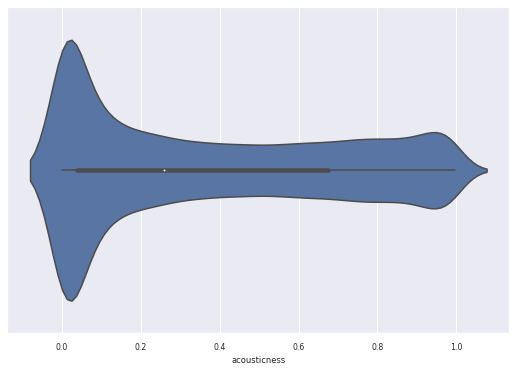

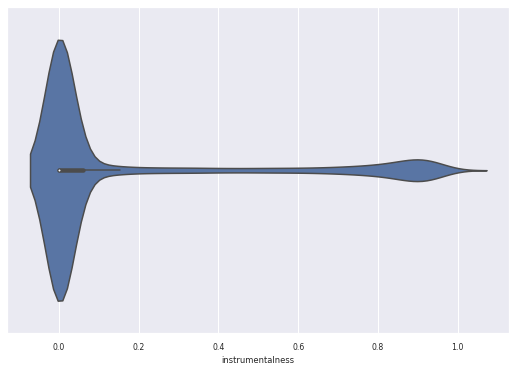

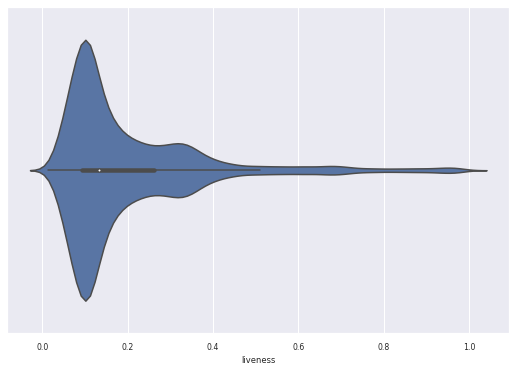

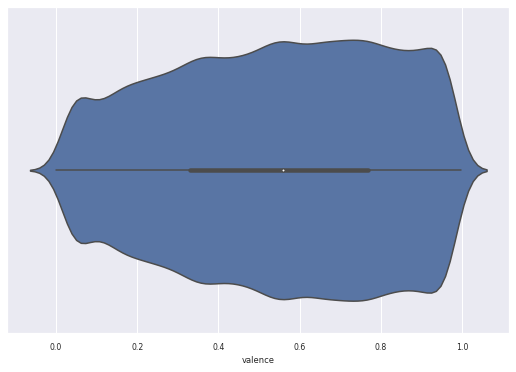

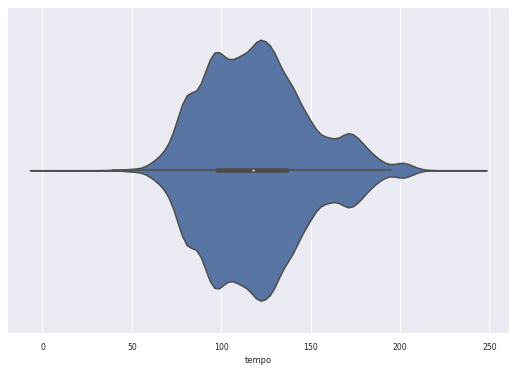

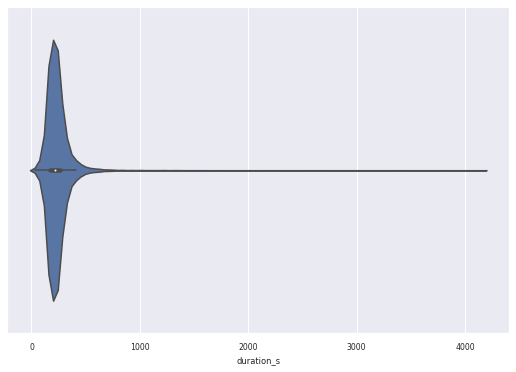

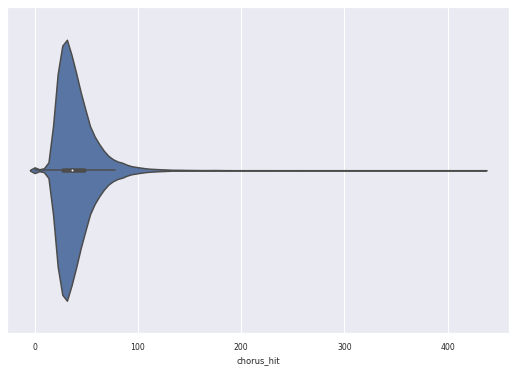

In [38]:
# Violin Plot for continuous numerical columns 
for column in data_numerical_columns:
   sb.violinplot(x=data[column])
   plt.show()

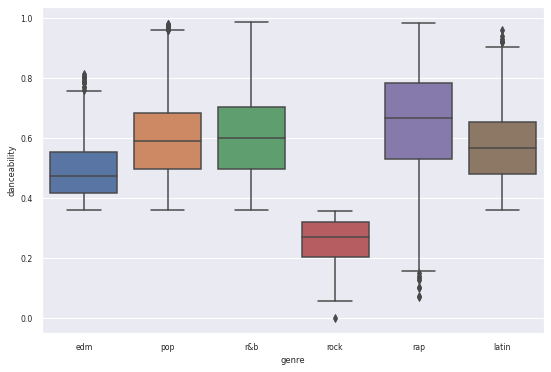

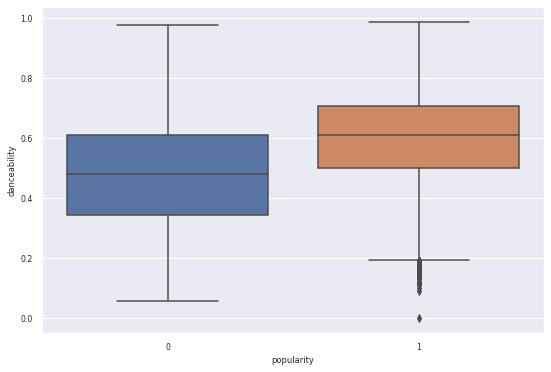

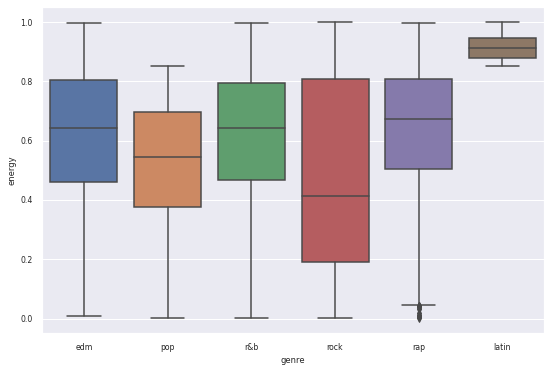

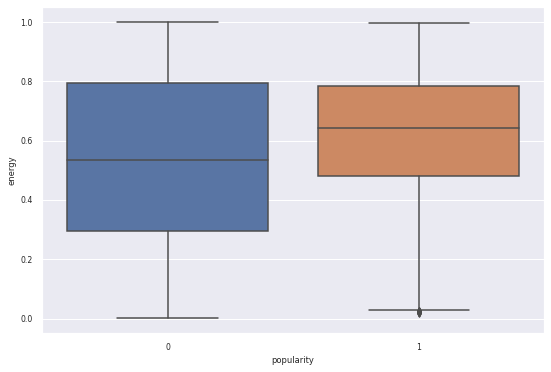

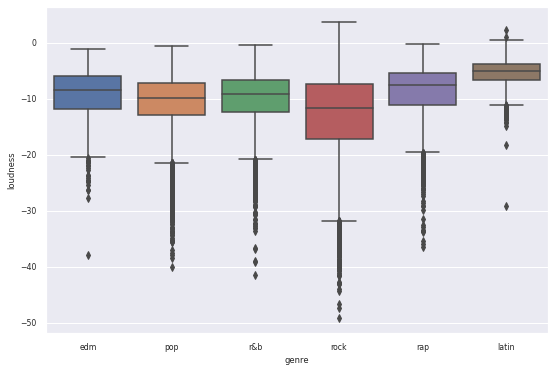

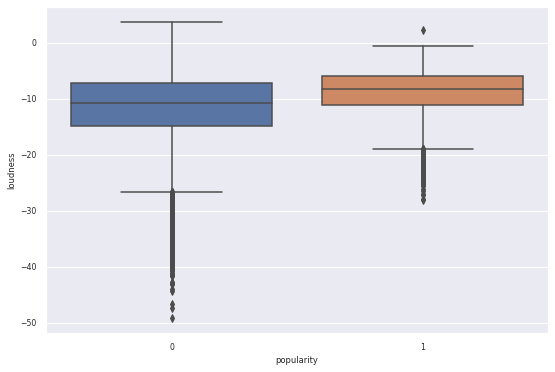

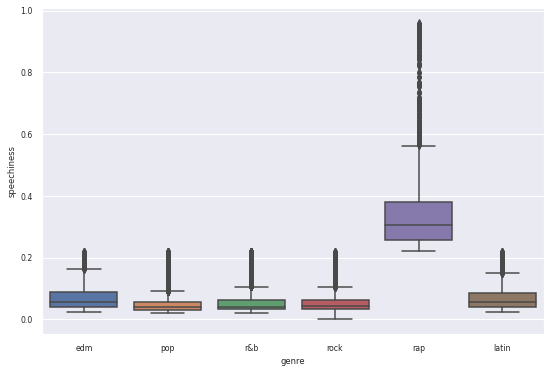

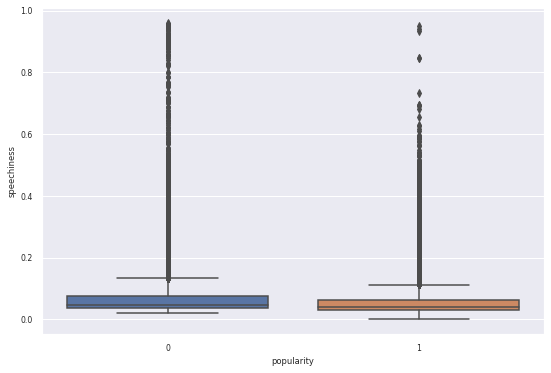

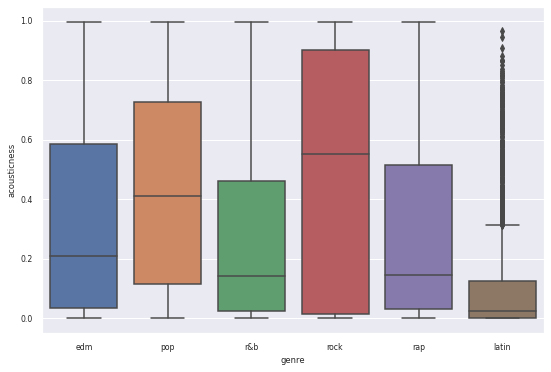

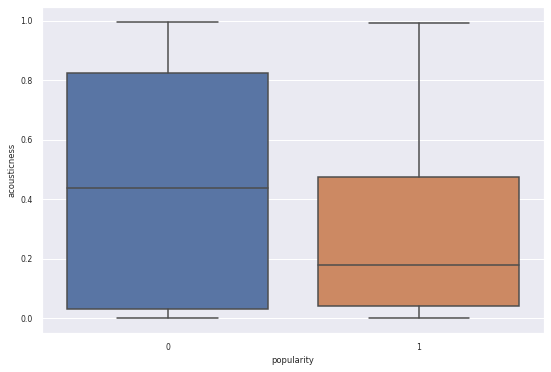

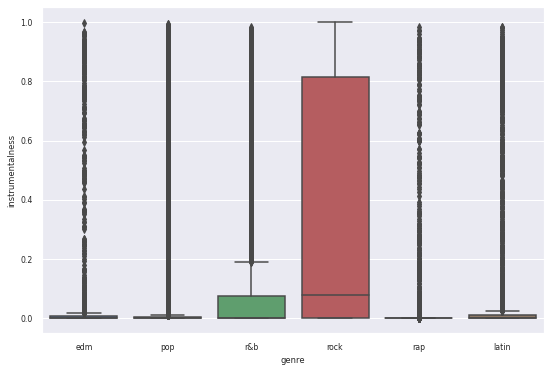

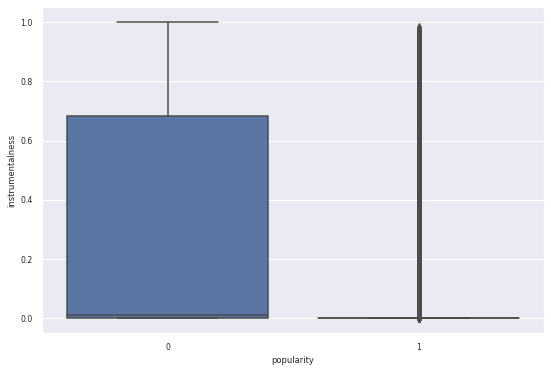

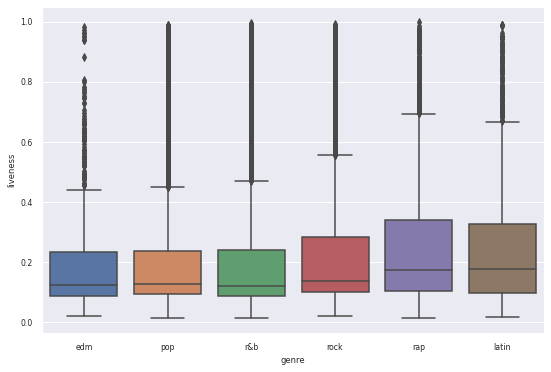

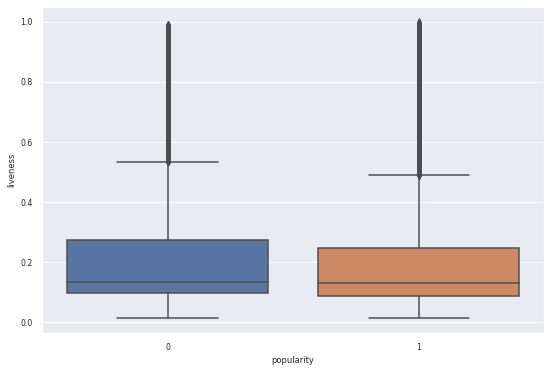

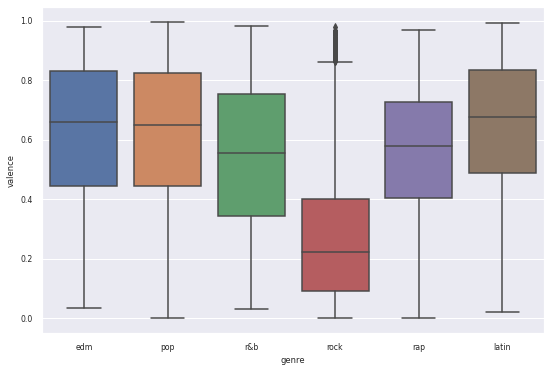

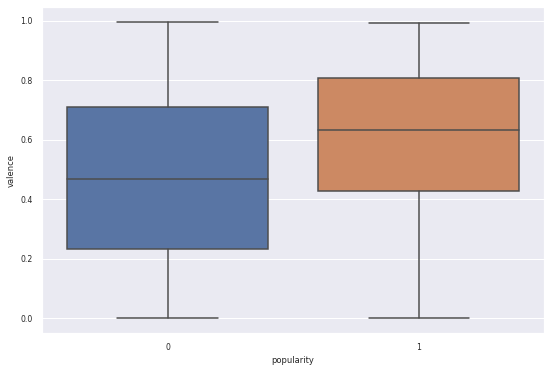

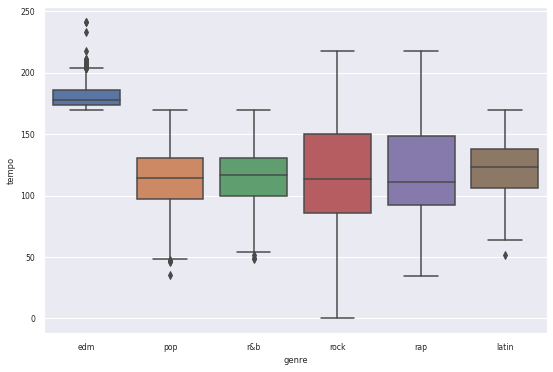

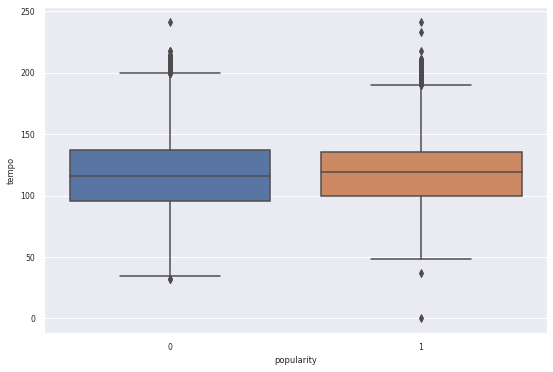

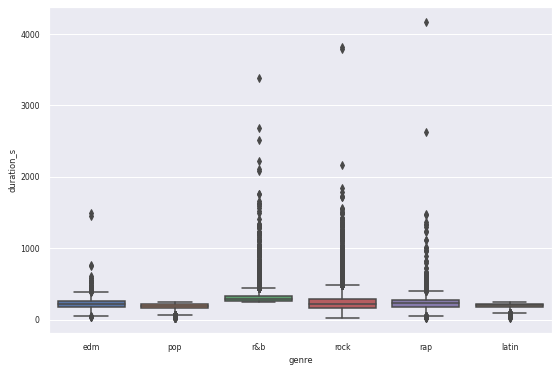

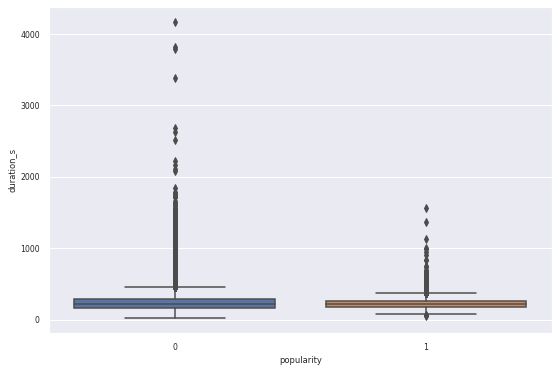

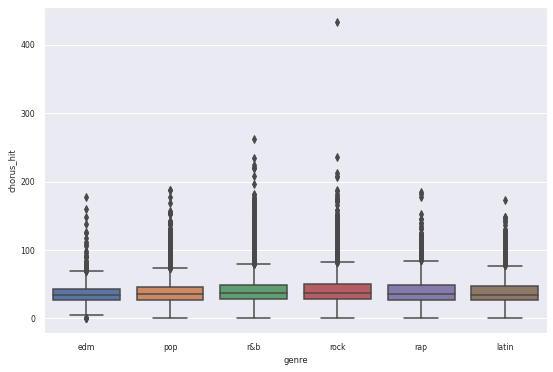

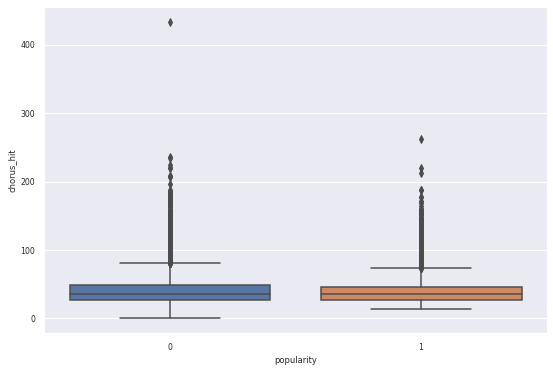

In [39]:
# Box plot detailing the selected numerical columns in terms of categorical columns.
for numerical_column in data_numerical_columns:
  for categorical_column in data_categorical_columns:
    sb.boxplot(x=categorical_column, y=numerical_column, data=data)
    plt.show()

In [40]:
# Manually pre-process data for a custom Bubble Plot in Bokeh.
df = pd.DataFrame(songs_count_per_genre, index = range(1))
df = df.transpose()
df["Genre"] = list(songs_count_per_genre.keys())
df.index = range(len(songs_count_per_genre))
df.columns = ["count", "Genre"]
scale = 100
df["count_scaled"] = [cnt/scale for cnt in list(df["count"])]
iqr_per_genre = [np.nanpercentile((data[data["genre"]==genre])["danceability"], [25, 75]) for genre in list(songs_count_per_genre.keys())]
df["popularity_iqr"] = [str(x[0])+"-"+str(x[1]) for x in iqr_per_genre]
source = ColumnDataSource(df)
p = figure(x_range = df['popularity_iqr'].unique(), y_range = df['Genre'].unique())

color_mapper = LinearColorMapper(palette = Viridis256, low = df['count'].min(), high = df['count'].max())
color_bar = ColorBar(color_mapper = color_mapper,
                     location = (0, 0),
                     ticker = BasicTicker())
p.add_layout(color_bar, 'right')
p.scatter(x = 'popularity_iqr', y = 'Genre', size = 'count_scaled', fill_color = transform('count', color_mapper), source = source)
p.add_tools(HoverTool(tooltips = [('Count', '@count')]))
show(p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



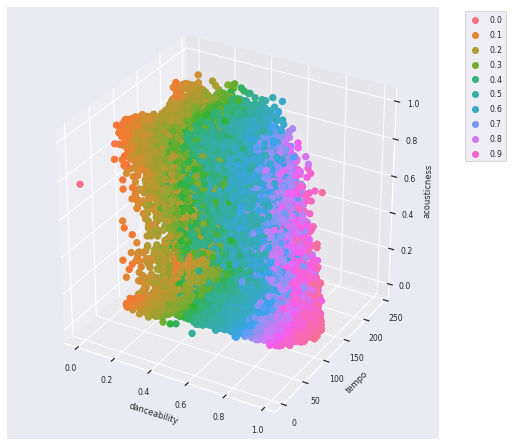

In [41]:
# 3D Scatterplot with danceability scores in Hue.
labels_to_plot = ["danceability", "tempo", "acousticness"]
x = list(data[labels_to_plot[0]])
y = list(data[labels_to_plot[1]])
z = list(data[labels_to_plot[2]])
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)
cmap = ListedColormap(sb.color_palette("husl", 256).as_hex())
sc = ax.scatter(x, y, z, s=40, c=x, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel(labels_to_plot[0])
ax.set_ylabel(labels_to_plot[1])
ax.set_zlabel(labels_to_plot[2])
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

In [42]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



In [43]:
# Create Dendogram DataSet.
labels_to_plot = ["sections", "key"]
x = list(data[labels_to_plot[0]])
y = list(data[labels_to_plot[1]])
dataset = []
for i in range(0,len(x)):
  dataset.append([x[i],y[i]])

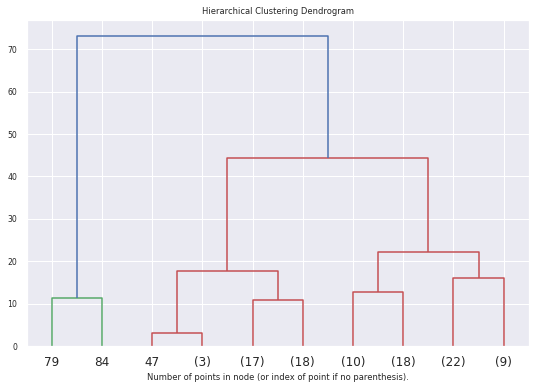

In [44]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(dataset[:100])
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

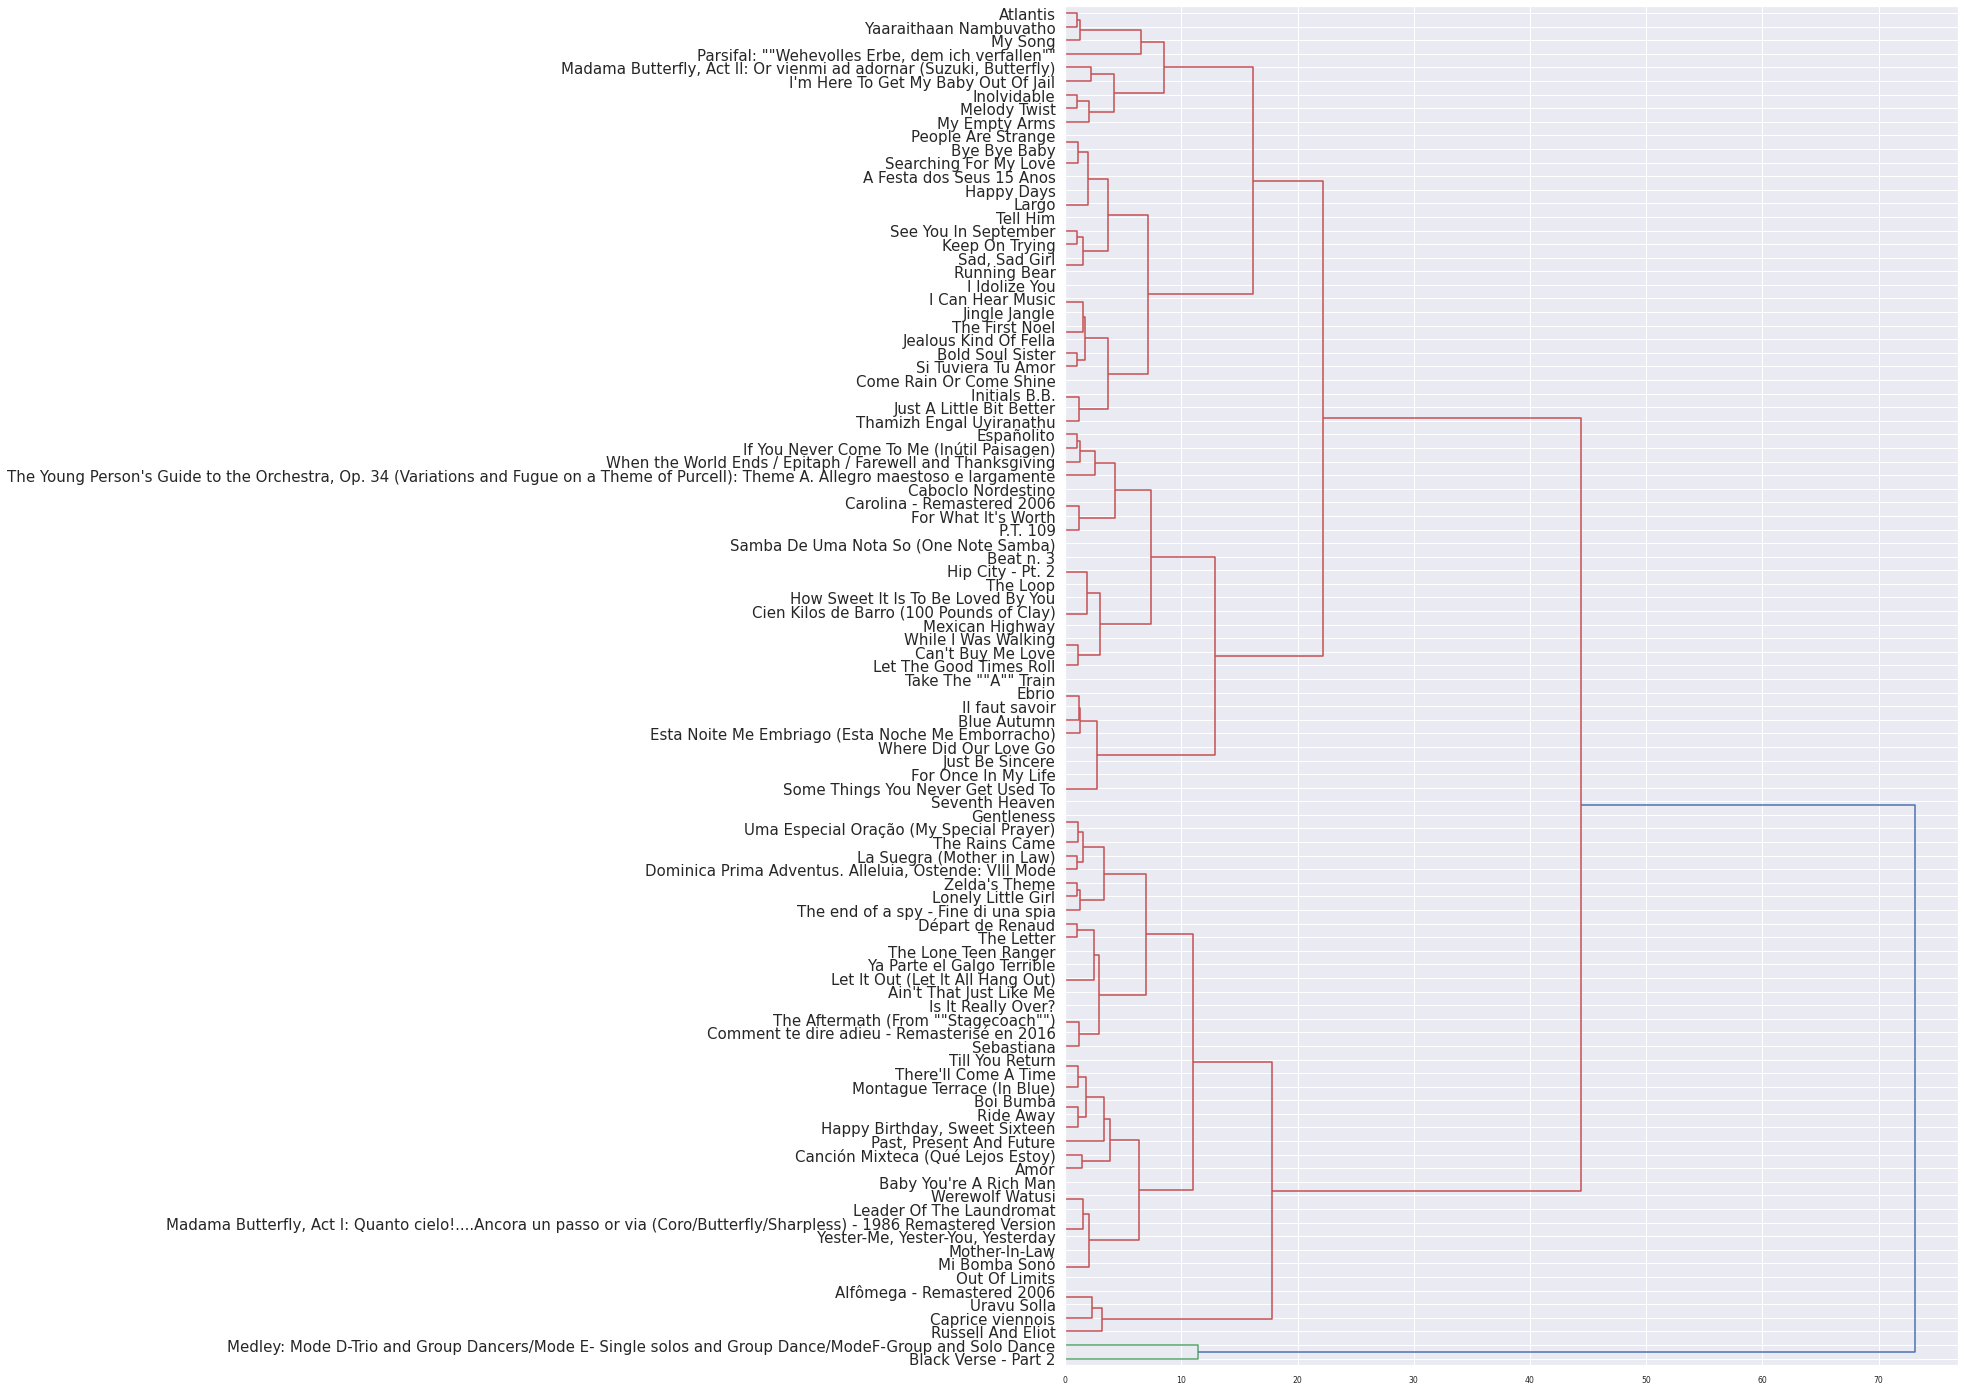

In [45]:
plt.rcParams["figure.figsize"] = [16,25]
Z = linkage(dataset[:100], 'ward')
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
dendrogram(Z, ax=ax, labels=list(data["track"][:100]), orientation="right")
ax.tick_params(axis='y', which='major', labelsize=15)

Sources for some of the plots:
- https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
- https://seaborn.pydata.org/generated/seaborn.boxplot.html
- https://seaborn.pydata.org/generated/seaborn.violinplot.html
- https://stackoverflow.com/questions/52285104/3d-scatterplots-in-python-with-hue-colormap-and-legend
- https://stackoverflow.com/questions/55567541/how-to-generate-bubble-chart-with-bokeh